In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.metrics import Precision, Recall
from focal_loss import BinaryFocalLoss
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from datetime import datetime
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm  
import cv2
from sklearn.preprocessing import LabelEncoder

In [22]:
# Set all random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [23]:
num_class=9
img_rows,img_cols=48,48 #image size
batch_size=16 #decrease from 32 to 16 back to 32

In [24]:
# For GPU determinism (if using GPU)
tf.config.experimental.enable_op_determinism()

In [25]:
# Regularization strength (tunable)
kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4) #new, l1_l2 regularisation

In [26]:
train_data=r"C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013\train"

validation_data=r"C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013\test"

In [27]:
# Get the list of folders in the directory as classes
classes=os.listdir(train_data+'/')
classes

['angry',
 'disgust',
 'fear',
 'happy',
 'kissing',
 'neutral',
 'sad',
 'sleepy',
 'surprise']

In [28]:
def get_class_distribution(dataset_path):
    class_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder)))
                    for folder in os.listdir(dataset_path)
                    if os.path.isdir(os.path.join(dataset_path, folder))}
    return class_counts


In [29]:
def plot_class_distribution(class_counts, title="Class Distribution"):
    df = pd.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Emotion', y='Count', data=df)
    plt.title(title)
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


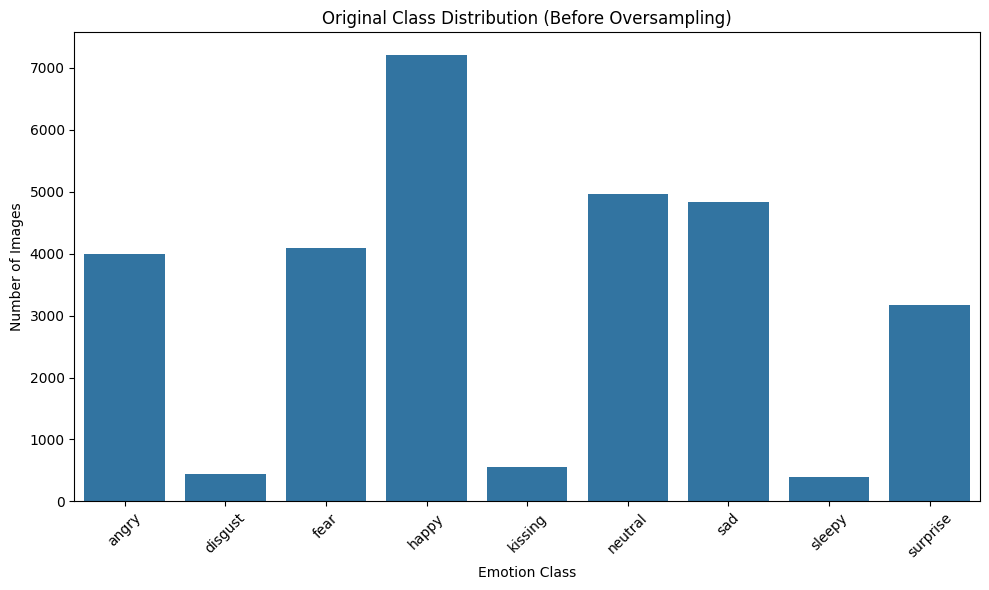

In [30]:
original_counts = get_class_distribution(train_data)
plot_class_distribution(original_counts, title="Original Class Distribution (Before Oversampling)")


In [31]:
OVERSAMPLED_TRAIN_PATH = r"C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013\oversampled_train"
TARGET_LENGTH = 8000  # Set to max class size or any desired balance

def oversample_dataset(train_dir=train_data, oversampled_dir=OVERSAMPLED_TRAIN_PATH, target_length=TARGET_LENGTH):
    if not os.path.exists(oversampled_dir):
        os.makedirs(oversampled_dir)

    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        num_images = len(images)
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        dest_dir = os.path.join(oversampled_dir, class_name)
        os.makedirs(dest_dir, exist_ok=True)

        # Duplicate all images num_duplicates times
        for i in range(num_duplicates):
            for image_name in images:
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(dest_dir, f"{i}_{image_name}")
                Image.open(src_path).save(dst_path)

        # Add remainder images
        for i, image_name in enumerate(images[:remainder]):
            src_path = os.path.join(class_path, image_name)
            dst_path = os.path.join(dest_dir, f"{num_duplicates}_{i}_{image_name}")
            Image.open(src_path).save(dst_path)

#oversample_dataset()

In [32]:
# def smote_augment_multi_folder(input_folder, output_folder, num_augmented_images=1000):
   

#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.15,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )

#     if not os.path.exists(input_folder):
#         print(f"[ERROR] Input folder does not exist: {input_folder}")
#         return

#     os.makedirs(output_folder, exist_ok=True)

#     for subfolder in os.listdir(input_folder):
#         input_subfolder_path = os.path.join(input_folder, subfolder)
#         output_subfolder_path = os.path.join(output_folder, subfolder)

#         if not os.path.isdir(input_subfolder_path):
#             continue

#         os.makedirs(output_subfolder_path, exist_ok=True)

#         image_files = [f for f in os.listdir(input_subfolder_path)
#                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

#         if not image_files:
#             print(f"[WARNING] No images in: {input_subfolder_path}")
#             continue

#         print(f"[INFO] Processing '{subfolder}' - {len(image_files)} images found")

#         count = 0
#         while count < num_augmented_images:
#             img_file = random.choice(image_files)
#             img_path = os.path.join(input_subfolder_path, img_file)

#             try:
#                 img = load_img(img_path)
#                 x = img_to_array(img)
#                 x = x.reshape((1,) + x.shape)

#                 # Generate a batch of 1 augmented image
#                 for batch in datagen.flow(x, batch_size=1):
#                     aug_img = array_to_img(batch[0])

#                     # Generate a unique filename
#                     timestamp = datetime.now().strftime('%Y%m%d%H%M%S%f')
#                     save_name = f"aug_{count}_{timestamp}.png"
#                     save_path = os.path.join(output_subfolder_path, save_name)

#                     aug_img.save(save_path)
#                     count += 1
#                     break

#             except Exception as e:
#                 print(f"[ERROR] Skipping file '{img_file}': {e}")
#                 continue

#         print(f"[DONE] Generated {count} images for '{subfolder}'")

#     print(f"\n[COMPLETE] All folders processed. Output saved to: {output_folder}")


In [33]:
# SMOTED_OVERSAMPLED_TRAIN_PATH=r"C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013 (USED)\SMOTED_OVERSAMPLED"

# smote_augment_multi_folder(
#     input_folder=train_data,
#     output_folder=SMOTED_OVERSAMPLED_TRAIN_PATH,
#     num_augmented_images=7215
# )

In [34]:
#SMOTED_OVERSAMPLED_TEST=R"C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013 (USED)\SMOTED_OVERSAMPLED_TEST"

# smote_augment_multi_folder(
#     input_folder=validation_data,
#     output_folder=SMOTED_OVERSAMPLED_TEST,
#     num_augmented_images=1774
# )

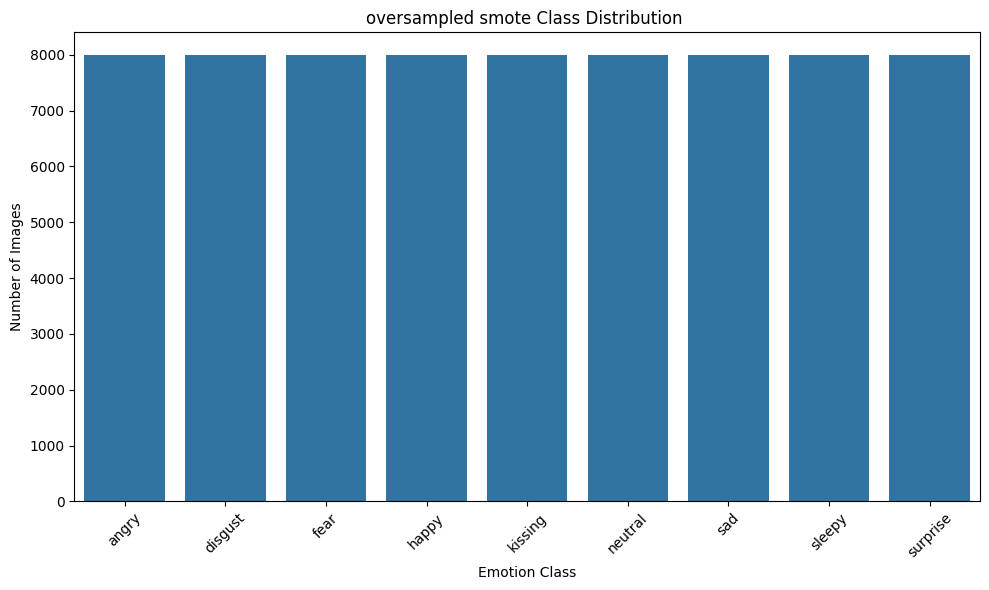

In [35]:
original_counts = get_class_distribution(OVERSAMPLED_TRAIN_PATH)
plot_class_distribution(original_counts, title="oversampled smote Class Distribution ")

In [36]:
#image data generator section

#here we generated some images 

train_dataGen=ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    rotation_range=15,           # Increase from 10 to 15
    shear_range=0.10,            # Increase from 0.1 to 0.2 back to 0.15
    zoom_range=0.10,             # Increase from 0.1 to 0.2 back to 0.15 back to 0.1
    width_shift_range=0.10,      # Increase from 0.1 to 0.2 back to 0.15
    height_shift_range=0.10,     # Increase from 0.1 to 0.2 back to 0.15
    horizontal_flip=True
    #brightness_range=[0.8, 1.2], # ADD: brightness variation- remove for now
    #channel_shift_range=0.1      # ADD: slight channel shift remove for now 
)


validation_dataGen=ImageDataGenerator(rescale=1./255)

#give to model to train-train parameters

train_generator = train_dataGen.flow_from_directory(
  OVERSAMPLED_TRAIN_PATH,
  color_mode='grayscale',
  target_size=(img_rows,img_cols) , 
  batch_size=batch_size,
  class_mode='categorical', 
  shuffle=True
   )

#new - add class weighs

from sklearn.utils.class_weight import compute_class_weight

labels = train_generator.classes  # Numpy array of class indices
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

#end of new

#validation parameters
validation_generator = validation_dataGen.flow_from_directory(validation_data,
color_mode='grayscale',
 target_size=(img_rows,img_cols) , 
 batch_size=batch_size,
   class_mode='categorical', 
   shuffle=True
   )

Found 72000 images belonging to 9 classes.
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0}
Found 7628 images belonging to 9 classes.


In [37]:
model= Sequential()

#change, block 1-4, increase dropout from 0.2 to 0.3 0.2
#change, block 5-6, decrease dropout from 0.5 to 0.4 0.3


# Block 1 - Deeper feature extraction
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001), input_shape=(img_rows, img_cols, 1)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Block 2 - Increased capacity
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Block 3 - Higher-level features
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# Block 4 - Complex pattern recognition
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# Block 5 - Additional deep features
model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())

model.add(Dropout(0.4))


# Global Average Pooling - reduces overfitting compared to Flatten
model.add(GlobalAveragePooling2D())


# Fully Connected Dense Layers
model.add(Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
model.add(Activation('swish'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# Output Layer
model.add(Dense(num_class, kernel_initializer='he_normal'))
model.add(Activation('softmax'))


print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 activation_17 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 activation_18 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                     

In [38]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(r'C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\Emotion_little_vgg.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=7, #increase from 3
                         verbose=1,
                         restore_best_weights=True
                         )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5, #change from 0.2
                            patience=5, #increase from 3
                            verbose=1,
                            min_delta=0.0001)

callbacks = [earlystop,reduce_lr]

optimizer = Adam(learning_rate=0.0001 , clipnorm=1.0)  # Reduced from 0.001

In [39]:
from tensorflow.keras import backend as K  

def f1_score(y_true, y_pred):
    """Custom F1 score metric"""
    def recall_fn(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_fn(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision_fn(y_true, y_pred)
    recall_val = recall_fn(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))


In [40]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall(),f1_score]
              )

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
epochs=60 #how many times to train same image, model will go 25 times in every folder #increase from 25


history=model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size,
                 class_weight=class_weights_dict )

model.save('FER_model.h5')

Epoch 1/60
4500/4500 [==============================] - 706s 156ms/step - loss: 2.9108 - accuracy: 0.2228 - precision_1: 0.3472 - recall_1: 0.1096 - f1_score: 0.1655 - val_loss: 2.6363 - val_accuracy: 0.2419 - val_precision_1: 0.4058 - val_recall_1: 0.0750 - val_f1_score: 0.1228 - lr: 1.0000e-04
Epoch 2/60
4500/4500 [==============================] - 457s 102ms/step - loss: 2.2653 - accuracy: 0.3730 - precision_1: 0.6608 - recall_1: 0.2076 - f1_score: 0.3111 - val_loss: 2.2330 - val_accuracy: 0.3728 - val_precision_1: 0.5526 - val_recall_1: 0.1925 - val_f1_score: 0.2797 - lr: 1.0000e-04
Epoch 3/60
4500/4500 [==============================] - 265s 59ms/step - loss: 1.9253 - accuracy: 0.4800 - precision_1: 0.7543 - recall_1: 0.3033 - f1_score: 0.4278 - val_loss: 1.9800 - val_accuracy: 0.4550 - val_precision_1: 0.6420 - val_recall_1: 0.2965 - val_f1_score: 0.3986 - lr: 1.0000e-04
Epoch 4/60
4500/4500 [==============================] - 317s 70ms/step - loss: 1.7096 - accuracy: 0.5418 - pre

Found 7628 images belonging to 9 classes.
477/477 [==============================] - 15s 31ms/step


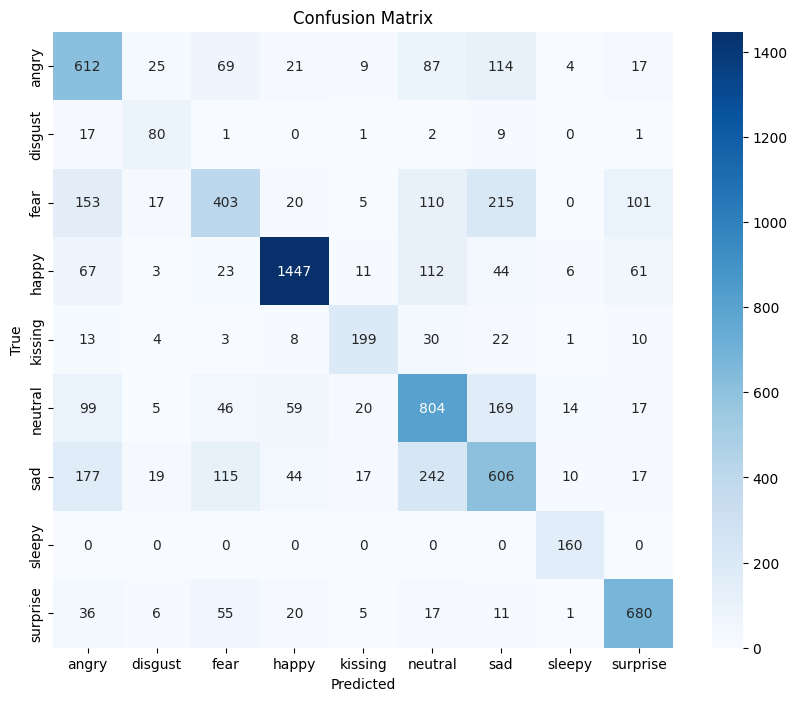

              precision    recall  f1-score   support

       angry       0.52      0.64      0.57       958
     disgust       0.50      0.72      0.59       111
        fear       0.56      0.39      0.46      1024
       happy       0.89      0.82      0.85      1774
     kissing       0.75      0.69      0.71       290
     neutral       0.57      0.65      0.61      1233
         sad       0.51      0.49      0.50      1247
      sleepy       0.82      1.00      0.90       160
    surprise       0.75      0.82      0.78       831

    accuracy                           0.65      7628
   macro avg       0.65      0.69      0.67      7628
weighted avg       0.66      0.65      0.65      7628



In [41]:
val_eval_generator = validation_dataGen.flow_from_directory(
    validation_data,
    color_mode='grayscale', 
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predict on validation data
Y_pred = model.predict(val_eval_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_eval_generator.classes

# Get class labels
class_names = list(val_eval_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
